In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
plt.rcParams.update({'font.size': 24, 'text.usetex': True})

torch.set_default_device('cuda')
torch.set_default_dtype(torch.float64)
print(f'Using CUDA device: {torch.cuda.get_device_name()}')

Using CUDA device: NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
N_values = 8 * np.arange(1, 9)
delta_values = [0.1, 0.05, 0.025]

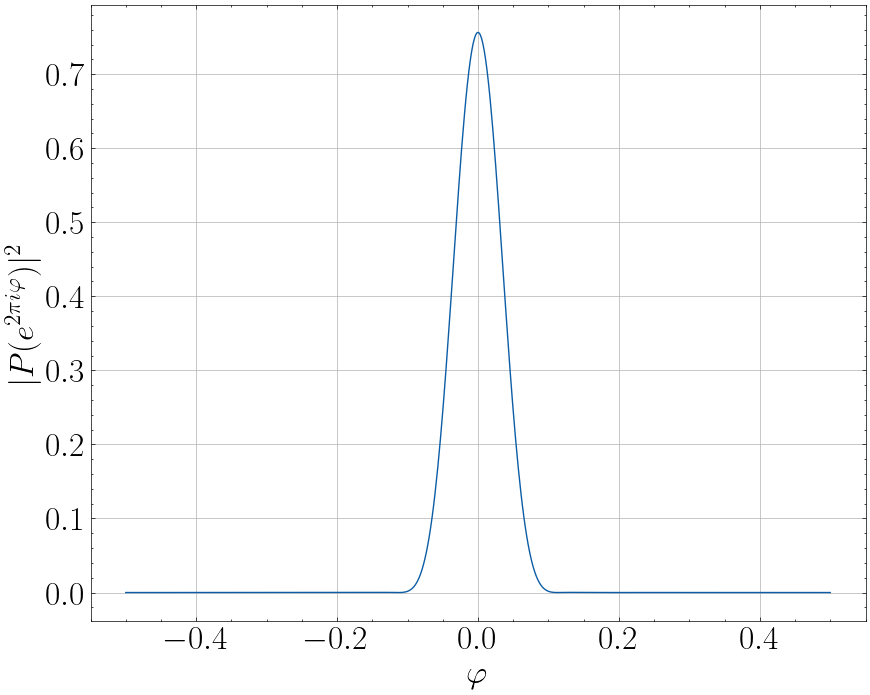

In [3]:
def construct_sine_polynomial(N, delta, theta):
    # Initialize sum of |p|^2
    sum_abs_p_sq = torch.zeros_like(theta, dtype=torch.float64)
        
    # Compute p(theta, theta_0)
    p_theta = torch.zeros_like(theta, dtype=torch.complex128)

    # Compute eigensystem
    mat = np.fromfunction(lambda j,k: 2 * delta * np.sinc((j - k) * 2 * delta), (N, N))
    np.fill_diagonal(mat, 2 * delta)

    eigvals, eigvecs = np.linalg.eigh(mat)
    argmax_eigenval = np.argmax(eigvals)
    # min_eigval = eigvals[argmin_eigenval]
    # print(f'Minimum eigenvalue: {min_eigval}')
    max_eigvec = eigvecs[:, argmax_eigenval]
    max_eigvec = max_eigvec / np.linalg.norm(max_eigvec)
    
    for k in range(N):
        phase = torch.exp(1j * k * 2 * np.pi * theta)
        p_theta += max_eigvec[k] * phase
    
    # Add |p|^2 to the sum
    sum_abs_p_sq += torch.abs(p_theta)**2
    
    # Return |P| = sqrt(sum of |p|^2)
    return sum_abs_p_sq / N

theta_vals = torch.linspace(-0.5, 0.5, 500)
P_vals = construct_sine_polynomial(16, delta_values[0], theta_vals)

plt.figure(figsize=(10, 8))
plt.plot(theta_vals.cpu().numpy(), P_vals.cpu().numpy())
plt.xlabel(r'$\varphi$')
plt.ylabel(r'$|P(e^{2\pi i \varphi})|^2$')
# plt.ylim(0, 1)
plt.grid(True)
plt.show()

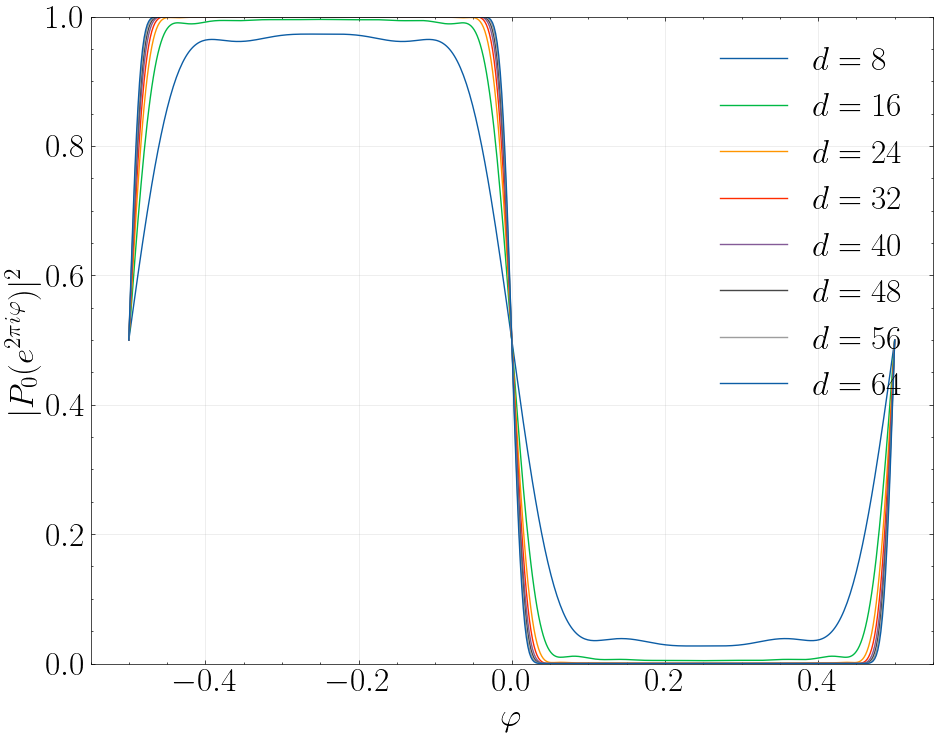

In [4]:
def generate_binary_decision_poly(N, delta, theta):
    ret = torch.zeros_like(theta, dtype=torch.float64)
    for j in range(N):
        ret += construct_sine_polynomial(N, delta, theta + (j + 0.5) / (2 * N))
    return ret / 2

# Plot for different N values
theta_vals = torch.linspace(-0.5, 0.5, 500)

plt.figure(figsize=(10, 8))
for N in N_values:
    P_vals = generate_binary_decision_poly(N, delta_values[1], theta_vals)
    plt.plot(theta_vals.cpu().numpy(), P_vals.cpu().numpy(), label=f'$d={N}$')

plt.xlabel(r'$\varphi$')
plt.ylabel(r'$|P_0(e^{2\pi i \varphi})|^2$')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('binary_decision.pdf')
plt.show()

In [5]:
# Calculate max error for binary decision polynomial
def calculate_binary_errors_multi(N, delta_values, n_theta=2000):
    theta = torch.linspace(-0.5, 0.5, n_theta, dtype=torch.float64)
    
    # Calculate max errors for each delta
    max_errors = []
    for delta in delta_values:
        P_vals = generate_binary_decision_poly(N, delta, theta)
        
        # Interval 1: [-0.5+delta, -delta] should be ~1
        mask_1 = (theta >= -0.5+delta) & (theta <= -delta)
        error_1 = torch.max(torch.abs(P_vals[mask_1] - 1.0))
        
        # Interval 2: [delta, 0.5-delta] should be ~0
        mask_2 = (theta >= delta) & (theta <= 0.5-delta)
        error_2 = torch.max(P_vals[mask_2])
        
        max_errors.append(max(error_1.item(), error_2.item()))
    
    return max_errors

# Calculate errors for different N values and delta values
errors_0 = []
errors_1 = []
errors_2 = []

for N in N_values:
    max_errors = calculate_binary_errors_multi(N, delta_values)
    errors_0.append(max_errors[0])
    errors_1.append(max_errors[1])
    errors_2.append(max_errors[2])
    print(f'N={N}: δ={delta_values[0]}: {errors_0[-1]:.6f}, δ={delta_values[1]}: {errors_1[-1]:.6f}, δ={delta_values[2]}: {errors_2[-1]:.6f}')

N=8: δ=0.1: 0.019233, δ=0.05: 0.142286, δ=0.025: 0.294491
N=16: δ=0.1: 0.000227, δ=0.05: 0.018849, δ=0.025: 0.141664
N=24: δ=0.1: 0.000002, δ=0.05: 0.001894, δ=0.025: 0.055830
N=32: δ=0.1: 0.000000, δ=0.05: 0.000231, δ=0.025: 0.018756
N=40: δ=0.1: 0.000000, δ=0.05: 0.000025, δ=0.025: 0.005729
N=48: δ=0.1: 0.000000, δ=0.05: 0.000002, δ=0.025: 0.001881
N=56: δ=0.1: 0.000000, δ=0.05: 0.000000, δ=0.025: 0.000677
N=64: δ=0.1: 0.000000, δ=0.05: 0.000000, δ=0.025: 0.000232


In [6]:
# # Plot error vs degree for binary decision polynomial
# plt.figure(figsize=(10, 8))

# # Plot max errors for different delta values
# plt.plot(N_values, errors_0, marker='o', linewidth=2,  label=r'$\varepsilon_{0.05}$')
# plt.plot(N_values, errors_1, marker='s', linewidth=2, label=r'$\varepsilon_{0.01}$')
# plt.plot(N_values, errors_2, marker='^', linewidth=2, label=r'$\varepsilon_{0.005}$')

# plt.xlabel(r'$d$')
# plt.ylabel(r'Error')
# plt.yscale('log')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# # plt.savefig('binary_error_vs_N.pdf')
# plt.show()


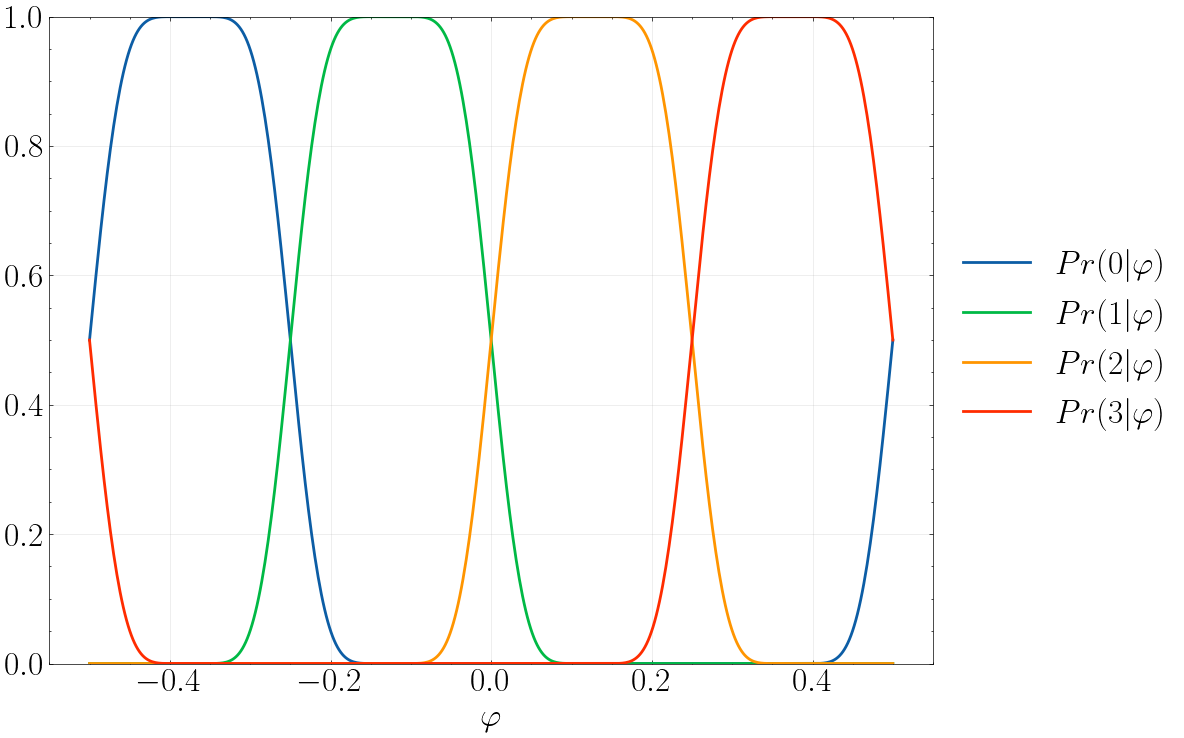

In [7]:
# 4-interval case: Generate 4 polynomials P0, P1, P2, P3
def generate_quatro_decision_poly(N, delta, theta):
    """
    Generate 4 polynomials for 4 intervals ordered from -0.5 to 0.5:
    - P0: interval 0 [-0.5, -0.25] -> j from N//4 to N//2-1
    - P1: interval 1 [-0.25, 0] -> j from 0 to N//4-1
    - P2: interval 2 [0, 0.25] -> j from 3N//4 to N-1
    - P3: interval 3 [0.25, 0.5] -> j from N//2 to 3N//4-1
    """
    P0 = torch.zeros_like(theta, dtype=torch.float64)
    P1 = torch.zeros_like(theta, dtype=torch.float64)
    P2 = torch.zeros_like(theta, dtype=torch.float64)
    P3 = torch.zeros_like(theta, dtype=torch.float64)
    
    quarter = N >> 2  # N//4
    # P0: interval 0 [-0.5, -0.25] from j=N/4 to N/2-1
    for j in range(N//2, N):
        P0 += construct_sine_polynomial(N, delta, theta + (j + 0.5) / (2 * N))
    # P1: interval 1 [-0.25, 0] from j=0 to N/4-1
    for j in range(N//2):
        P1 += construct_sine_polynomial(N, delta, theta + (j + 0.5) / (2 * N))
    # P2: interval 2 [0, 0.25] from j=3N/4 to N-1
    for j in range(N//2*3, N*2):
        P2 += construct_sine_polynomial(N, delta, theta + (j + 0.5) / (2 * N))
    # P3: interval 3 [0.25, 0.5] from j=N/2 to 3N/4-1
    for j in range(N, N//2*3):
        P3 += construct_sine_polynomial(N, delta, theta + (j + 0.5) / (2 * N))
    # Return in order: interval 0, 1, 2, 3
    return P0/2, P1/2, P2/2, P3/2

N = 16
theta_vals = torch.linspace(-0.5, 0.5, 500)
P0, P1, P2, P3 = generate_quatro_decision_poly(N, delta_values[0], theta_vals)

plt.figure(figsize=(10, 8))
plt.plot(theta_vals.cpu().numpy(), P0.cpu().numpy(), label='$Pr(0|\\varphi)$', linewidth=2)
plt.plot(theta_vals.cpu().numpy(), P1.cpu().numpy(), label='$Pr(1|\\varphi)$', linewidth=2)
plt.plot(theta_vals.cpu().numpy(), P2.cpu().numpy(), label='$Pr(2|\\varphi)$', linewidth=2)
plt.plot(theta_vals.cpu().numpy(), P3.cpu().numpy(), label='$Pr(3|\\varphi)$', linewidth=2)
plt.xlabel(r'$\varphi$')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('quatro_decision.pdf', bbox_inches='tight')
plt.show()


In [8]:
# Calculate max error for 4-interval decision polynomial
def calculate_quatro_errors_multi(N, delta_values, n_theta=2000):
    theta = torch.linspace(-0.5, 0.5, n_theta, dtype=torch.float64)
    
    # Calculate max errors for each delta
    max_errors = []
    for delta in delta_values:
        P0, P1, P2, P3 = generate_quatro_decision_poly(N, delta, theta)
        
        # P0, P1, P2, P3 correspond to intervals 0, 1, 2, 3 from -0.5 to 0.5:
        # P0→[-0.5,-0.25], P1→[-0.25,0], P2→[0,0.25], P3→[0.25,0.5]
        P_intervals = [P0, P1, P2, P3]
        
        errors_list = []
        
        # Interval 0: [-0.5+δ, -0.25-δ] should have P_intervals[0]~1
        mask_0 = (theta >= -0.5+delta) & (theta <= -0.25-delta)
        if mask_0.any():
            errors_list.append(torch.max(torch.abs(P_intervals[0][mask_0] - 1.0)).item())
            errors_list.extend([torch.max(P_intervals[i][mask_0]).item() for i in [1,2,3]])
        
        # Interval 1: [-0.25+δ, -δ] should have P_intervals[1]~1
        mask_1 = (theta >= -0.25+delta) & (theta <= -delta)
        if mask_1.any():
            errors_list.append(torch.max(torch.abs(P_intervals[1][mask_1] - 1.0)).item())
            errors_list.extend([torch.max(P_intervals[i][mask_1]).item() for i in [0,2,3]])
        
        # Interval 2: [δ, 0.25-δ] should have P_intervals[2]~1
        mask_2 = (theta >= delta) & (theta <= 0.25-delta)
        if mask_2.any():
            errors_list.append(torch.max(torch.abs(P_intervals[2][mask_2] - 1.0)).item())
            errors_list.extend([torch.max(P_intervals[i][mask_2]).item() for i in [0,1,3]])
        
        # Interval 3: [0.25+δ, 0.5-δ] should have P_intervals[3]~1
        mask_3 = (theta >= 0.25+delta) & (theta <= 0.5-delta)
        if mask_3.any():
            errors_list.append(torch.max(torch.abs(P_intervals[3][mask_3] - 1.0)).item())
            errors_list.extend([torch.max(P_intervals[i][mask_3]).item() for i in [0,1,2]])
        
        max_errors.append(max(errors_list) if errors_list else 0)
    
    return max_errors

# Calculate errors for different N values
errors_4_0 = []
errors_4_1 = []
errors_4_2 = []

for N in N_values:
    max_errors = calculate_quatro_errors_multi(N, delta_values)
    errors_4_0.append(max_errors[0])
    errors_4_1.append(max_errors[1])
    errors_4_2.append(max_errors[2])
    print(f'N={N}: δ={delta_values[0]}: {errors_4_0[-1]:.6f}, δ={delta_values[1]}: {errors_4_1[-1]:.6f}, δ={delta_values[2]}: {errors_4_2[-1]:.6f}')

N=8: δ=0.1: 0.027181, δ=0.05: 0.158415, δ=0.025: 0.312065
N=16: δ=0.1: 0.000324, δ=0.05: 0.021812, δ=0.025: 0.149039
N=24: δ=0.1: 0.000003, δ=0.05: 0.002286, δ=0.025: 0.059122
N=32: δ=0.1: 0.000000, δ=0.05: 0.000267, δ=0.025: 0.020048
N=40: δ=0.1: 0.000000, δ=0.05: 0.000028, δ=0.025: 0.006180
N=48: δ=0.1: 0.000000, δ=0.05: 0.000003, δ=0.025: 0.002042
N=56: δ=0.1: 0.000000, δ=0.05: 0.000000, δ=0.025: 0.000729
N=64: δ=0.1: 0.000000, δ=0.05: 0.000000, δ=0.025: 0.000248


## Two-Stage Binary Decision for 4 Intervals (Baseline)

Alternative approach using iterative U(2)-QSP with total degree $2d$:
1. **Stage 1**: Binary split at $\varphi = 0$ (left vs. right half)
2. **Stage 2**: Binary split within each half at $\varphi = \pm 0.25$

Final probabilities are products of the two stages. This requires $2d$ queries vs. $d$ for U(4)-QSP.

In [9]:
def generate_twostage_decision_poly(N, delta, theta):
    """
    Two-stage binary decision for 4 intervals using total degree 2N.
    Stage 1: Split at φ=0 (left vs right)
    Stage 2a: Within left half, split at φ=-0.25
    Stage 2b: Within right half, split at φ=0.25
    
    Returns 4 polynomials for intervals:
    - P0: [-0.5, -0.25]
    - P1: [-0.25, 0]
    - P2: [0, 0.25]
    - P3: [0.25, 0.5]
    """
    # Stage 1: Binary decision at φ=0
    P_left = generate_binary_decision_poly(N, delta, theta)  # ~1 for φ < 0
    P_right = 1.0 - P_left  # ~1 for φ > 0
    
    # Stage 2a: Within left half, split at -0.25
    # Shift by 0.25 so decision is at 0
    P_split_left = generate_binary_decision_poly(N, delta, theta + 0.25)  # ~1 for φ < -0.25
    
    # Stage 2b: Within right half, split at 0.25
    # Shift by -0.25 so decision is at 0
    P_split_right = generate_binary_decision_poly(N, delta, theta - 0.25)  # ~1 for φ < 0.25
    
    # Combine:
    # P0: [-0.5, -0.25] = left AND (φ < -0.25)
    P0 = P_left * P_split_left
    
    # P1: [-0.25, 0] = left AND (φ > -0.25)
    P1 = P_left * (1.0 - P_split_left)
    
    # P2: [0, 0.25] = right AND (φ < 0.25)
    P2 = P_right * P_split_right
    
    # P3: [0.25, 0.5] = right AND (φ > 0.25)
    P3 = P_right * (1.0 - P_split_right)
    
    return P0, P1, P2, P3

# # Test with N=16 (total degree = 2*16 = 32)
# N = 16
# theta_vals = torch.linspace(-np.pi, np.pi, 500)
# P0_ts, P1_ts, P2_ts, P3_ts = generate_twostage_decision_poly(N, delta, theta_vals)

# plt.figure(figsize=(10, 8))
# plt.plot(theta_vals.cpu().numpy(), P0_ts.cpu().numpy(), label='$P_0$', linewidth=2)
# plt.plot(theta_vals.cpu().numpy(), P1_ts.cpu().numpy(), label='$P_1$', linewidth=2)
# plt.plot(theta_vals.cpu().numpy(), P2_ts.cpu().numpy(), label='$P_2$', linewidth=2)
# plt.plot(theta_vals.cpu().numpy(), P3_ts.cpu().numpy(), label='$P_3$', linewidth=2)
# plt.xlabel(r'$\theta$')
# plt.ylabel(r'$|P_k(e^{i\theta})|^2$')
# plt.ylim(0, 1)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('twostage_decision.pdf', bbox_inches='tight')
# plt.show()


In [10]:
# Calculate errors for two-stage approach
def calculate_twostage_errors_multi(N, delta_values, n_theta=2000):
    """Calculate errors for two-stage binary decision with total degree 2N"""
    theta = torch.linspace(-0.5, 0.5, n_theta, dtype=torch.float64)
    
    # Calculate max errors for each delta
    max_errors = []
    for delta in delta_values:
        P0, P1, P2, P3 = generate_twostage_decision_poly(N, delta, theta)
        
        P_intervals = [P0, P1, P2, P3]
        
        errors_list = []
        
        # Interval 0: [-0.5+δ, -0.25-δ] should have P0~1
        mask_0 = (theta >= -0.5+delta) & (theta <= -0.25-delta)
        if mask_0.any():
            errors_list.append(torch.max(torch.abs(P_intervals[0][mask_0] - 1.0)).item())
            errors_list.extend([torch.max(P_intervals[i][mask_0]).item() for i in [1,2,3]])
        
        # Interval 1: [-0.25+δ, -δ] should have P1~1
        mask_1 = (theta >= -0.25+delta) & (theta <= -delta)
        if mask_1.any():
            errors_list.append(torch.max(torch.abs(P_intervals[1][mask_1] - 1.0)).item())
            errors_list.extend([torch.max(P_intervals[i][mask_1]).item() for i in [0,2,3]])
        
        # Interval 2: [δ, 0.25-δ] should have P2~1
        mask_2 = (theta >= delta) & (theta <= 0.25-delta)
        if mask_2.any():
            errors_list.append(torch.max(torch.abs(P_intervals[2][mask_2] - 1.0)).item())
            errors_list.extend([torch.max(P_intervals[i][mask_2]).item() for i in [0,1,3]])
        
        # Interval 3: [0.25+δ, 0.5-δ] should have P3~1
        mask_3 = (theta >= 0.25+delta) & (theta <= 0.5-delta)
        if mask_3.any():
            errors_list.append(torch.max(torch.abs(P_intervals[3][mask_3] - 1.0)).item())
            errors_list.extend([torch.max(P_intervals[i][mask_3]).item() for i in [0,1,2]])
        
        max_errors.append(max(errors_list) if errors_list else 0)
    
    return max_errors

# Calculate errors for different N values (half the degree since we use 2N total)
errors_ts_0 = []
errors_ts_1 = []
errors_ts_2 = []

for N in N_values:
    max_errors = calculate_twostage_errors_multi(N, delta_values)
    errors_ts_0.append(max_errors[0])
    errors_ts_1.append(max_errors[1])

    errors_ts_2.append(max_errors[2])
    print(f'N={N} (total d={2*N}): δ={delta_values[0]}: {errors_ts_0[-1]:.6f}, δ={delta_values[1]}: {errors_ts_1[-1]:.6f}, δ={delta_values[2]}: {errors_ts_2[-1]:.6f}')

N=8 (total d=16): δ=0.1: 0.030620, δ=0.05: 0.167168, δ=0.025: 0.319645
N=16 (total d=32): δ=0.1: 0.000364, δ=0.05: 0.023690, δ=0.025: 0.153706
N=24 (total d=48): δ=0.1: 0.000003, δ=0.05: 0.002531, δ=0.025: 0.061486
N=32 (total d=64): δ=0.1: 0.000000, δ=0.05: 0.000291, δ=0.025: 0.021057
N=40 (total d=80): δ=0.1: 0.000000, δ=0.05: 0.000030, δ=0.025: 0.006562
N=48 (total d=96): δ=0.1: 0.000000, δ=0.05: 0.000003, δ=0.025: 0.002171
N=56 (total d=112): δ=0.1: 0.000000, δ=0.05: 0.000000, δ=0.025: 0.000771
N=64 (total d=128): δ=0.1: 0.000000, δ=0.05: 0.000000, δ=0.025: 0.000261


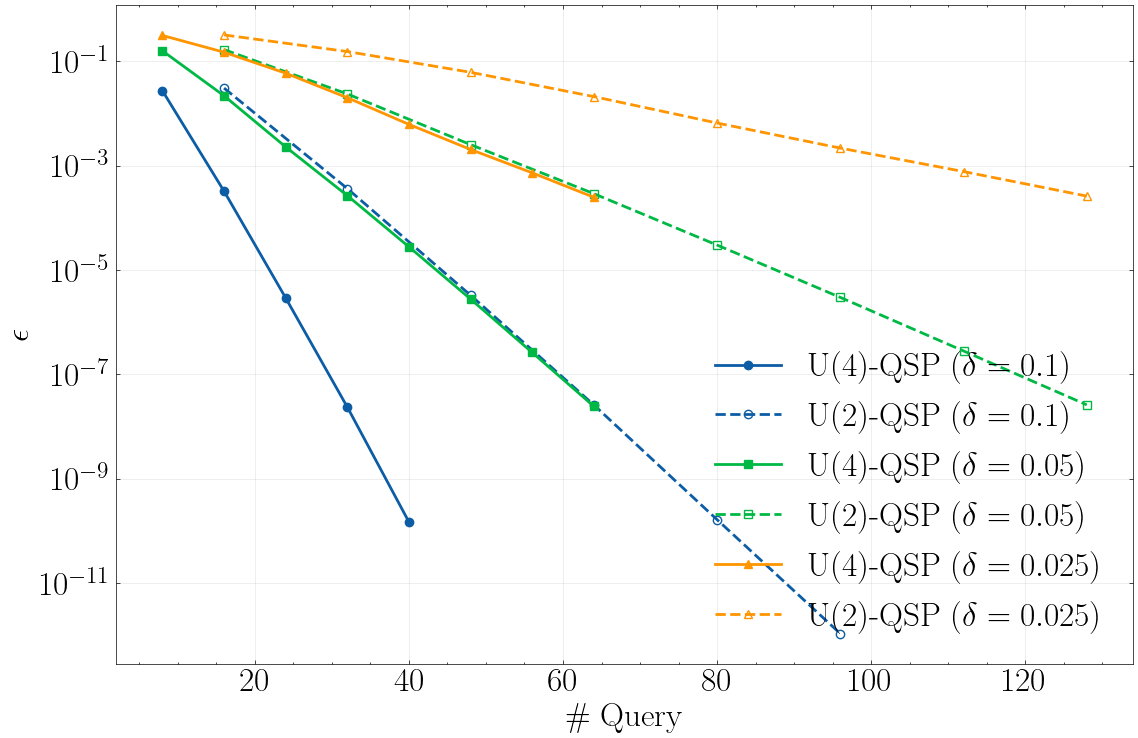

In [15]:
# Compare both approaches - max errors for different delta values
plt.figure(figsize=(12, 8))

# Convert N values to total degree for two-stage
total_degree_ts = [2*N for N in N_values]

# Filter out epsilon values below 1e-12
eps_threshold = 1e-12

def filter_data(x_vals, y_vals, threshold=eps_threshold):
    x_filtered = [x for x, y in zip(x_vals, y_vals) if y >= threshold]
    y_filtered = [y for y in y_vals if y >= threshold]
    return x_filtered, y_filtered

# Plot max errors for different delta values
x_4_0, y_4_0 = filter_data(N_values, errors_4_0)
x_ts_0, y_ts_0 = filter_data(total_degree_ts, errors_ts_0)
plt.plot(x_4_0, y_4_0, marker='o', linewidth=2, 
        label=f'U(4)-QSP ($\\delta={delta_values[0]}$)', color='C0')
plt.plot(x_ts_0, y_ts_0, marker='o', linewidth=2, 
        label=f'U(2)-QSP ($\\delta={delta_values[0]}$)', color='C0', linestyle='--', fillstyle='none')

x_4_1, y_4_1 = filter_data(N_values, errors_4_1)
x_ts_1, y_ts_1 = filter_data(total_degree_ts, errors_ts_1)
plt.plot(x_4_1, y_4_1, marker='s', linewidth=2, 
        label=f'U(4)-QSP ($\\delta={delta_values[1]}$)', color='C1')
plt.plot(x_ts_1, y_ts_1, marker='s', linewidth=2, 
        label=f'U(2)-QSP ($\\delta={delta_values[1]}$)', color='C1', linestyle='--', fillstyle='none')

x_4_2, y_4_2 = filter_data(N_values, errors_4_2)
x_ts_2, y_ts_2 = filter_data(total_degree_ts, errors_ts_2)
plt.plot(x_4_2, y_4_2, marker='^', linewidth=2, 
        label=f'U(4)-QSP ($\\delta={delta_values[2]}$)', color='C2')
plt.plot(x_ts_2, y_ts_2, marker='^', linewidth=2, 
        label=f'U(2)-QSP ($\\delta={delta_values[2]}$)', color='C2', linestyle='--', fillstyle='none')

plt.xlabel('\\# Query')
plt.ylabel('$\\epsilon$')
plt.yscale('log')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('quatro_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()
